# HSST B10m Data pre-processign with SVM Basic Examples
### Introduction
The below are worked examples from the slides to help support learning. 


In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import loguniform
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC

The below is a helper method to plot the SVM boundaries between two variables.

In [99]:
def decision_plot(X,y,clf,x_axis_label="PC1", y_axis_label="PC2"):
    """
    Based on answer provided by S. Loukas on StackOverflow.
    https://stackoverflow.com/questions/51495819/how-to-plot-svm-decision-boundary-in-sklearn-python
    """
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of linear SVC ')

    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel(y_axis_label)
    ax.set_xlabel(x_axis_label)
    ax.set_title(title)

    plt.show()

### Body Temperature
Simple body temp example, where we have a high/low range that is outside of norma.

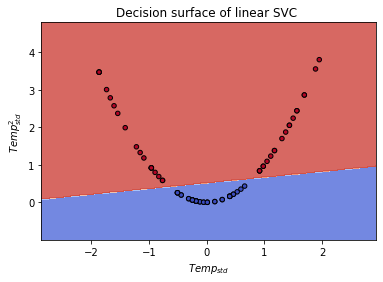

In [120]:
# generate equal amounts of data:   34-35.8C (n = 20), 36-38 (n=40), 38.2-40 (n=20)
t = np.r_[np.random.randint(340,358,20),np.random.randint(360,380,40), np.random.randint(382,400,20)]/10
# label the data, 0 for ok, and 1 for outside healthy range.
y = np.zeros(80)
y = np.where(t<36,1,y)
y = np.where(t>38,1,y)

# manual standardise
z=(t-np.mean(t))/np.std(t,ddof=1)

# add pseudo-dimension as a "Kernel trick"
X=np.c_[z, z**2]

# fit an SVM and plot, we set the regularisation parameter to 1
model = SVC(kernel='linear', C=100)
clf = model.fit(X,y)
# plot to show the classification.
decision_plot(X,y,clf,r"$Temp_{std}$",r"$Temp^2_{std}$")

### Wine Dataset
Here we use the wine dataset which we worked through in the slides and complete the example by using an SVM to split the data into 3 classes. The SVM is naturally a binary classify, so to make it multiclass we need to do either one-vs-one with the classes or one-vs-rest, the sckit-learn implementaiton is 1-vs-1.

This is based on:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html

In [ ]:
# Load data and plit into test/train samples

X, y = load_wine(return_X_y=True, as_frame=True)
target_classes = range(0, 3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

for standardise in [False, True]:
    # Optionally standardise data, we iterate over both to compare.
    if standardise:
        print("Example ran with Standardisation")
        scaler = StandardScaler()#.set_output(transform="pandas")
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)
    else: 
        print("Example ran without Standardisation")
        scaled_X_train = X_train
        scaled_X_test = X_test
    
    # perform PCA, we use 2 so that we can plot readily.
    print("PCA")
    n_components = 2
    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(scaled_X_train)  
    X_train_pca = pca.transform(scaled_X_train)
    X_test_pca = pca.transform(scaled_X_test)
    
    # fit a linear SVM, note we do a randomize search on C between 1 and 100.
    # if you wish to observe rbf/poly then you need to include the gamma with sensible ranges.
    param_grid = {
        "C": loguniform(1e0, 1e2),
        #"gamma": loguniform(1e-4, 1e0),
    }
    clf = RandomizedSearchCV(
        SVC(kernel="linear", class_weight="balanced"), param_grid, n_iter=10
    )
    clf = clf.fit(X_train_pca, y_train)
    
    # print out the coefs for the best fit
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    
    # plot the boundaries between classes in PC1 and PC2 space.
    decision_plot(X_train_pca, y_train,clf)
    y_pred = clf.predict(X_train_pca)
    
    # run classification reports on the training and test data
    print("Training data")
    print(classification_report(y_train, y_pred, target_names=np.char.mod("Class %d",target_classes)))
    y_pred = clf.predict(X_test_pca)
    print("Test data")
    print(classification_report(y_test, y_pred, target_names=np.char.mod("Class %d",target_classes)))
    print("-------------------")